In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk
from collections import Counter

In [2]:
#tokenization resources
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
from nltk.corpus import words
nltk.download('words')

[nltk_data] Downloading package wordnet to /Users/sarah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/sarah/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
#for NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


In [371]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 28.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [372]:
#for coherence implementation
from gensim.models import Word2Vec
from itertools import combinations
from operator import itemgetter

### Data Cleaning & EDA

Our dataset is a collection of 18,000 newsgroup documents from 20 different newgroups. The dataset has been split into training and testing subsets. We will be training our topic model on the larger subset, the training set. Since our algorithm is an unsupervised machine learning algorithm, we will not be using the test set. Additionally, the target values for the 20 different newsgroups will be used to assess the evaluation of our model in correctly extracting relevant topics.

In [250]:
# import dataset from sklearn

from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset='train')

The data is split into document contents and targets. The 20 newsgroup targets are show below.

In [251]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

An example of a document and its corresponding newsgroup is illustrated. _Data_ includes the content of the newsgroup document, _target_ includes the index of the category of the newsgroup, and _target_names_ includes the name of the category of the newsgroup.

In [252]:
dataset.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [253]:
dataset.target[0], dataset.target_names[dataset.target[0]]

(7, 'rec.autos')

We can represent this data as a dataframe for more efficient data cleaning and data exploration.

In [254]:
newsgroup_df = pd.DataFrame({"document": dataset.data, "target": dataset.target})
newsgroup_df = newsgroup_df.assign(newsgroup=newsgroup_df["target"].apply(lambda x: dataset.target_names[x]))
newsgroup_df.head()

,document,target,newsgroup
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


Let's do some exploratory data analysis to better understand our dataset. First, we can look at the distribution of our newsgroup targets to see if there are any outliers.

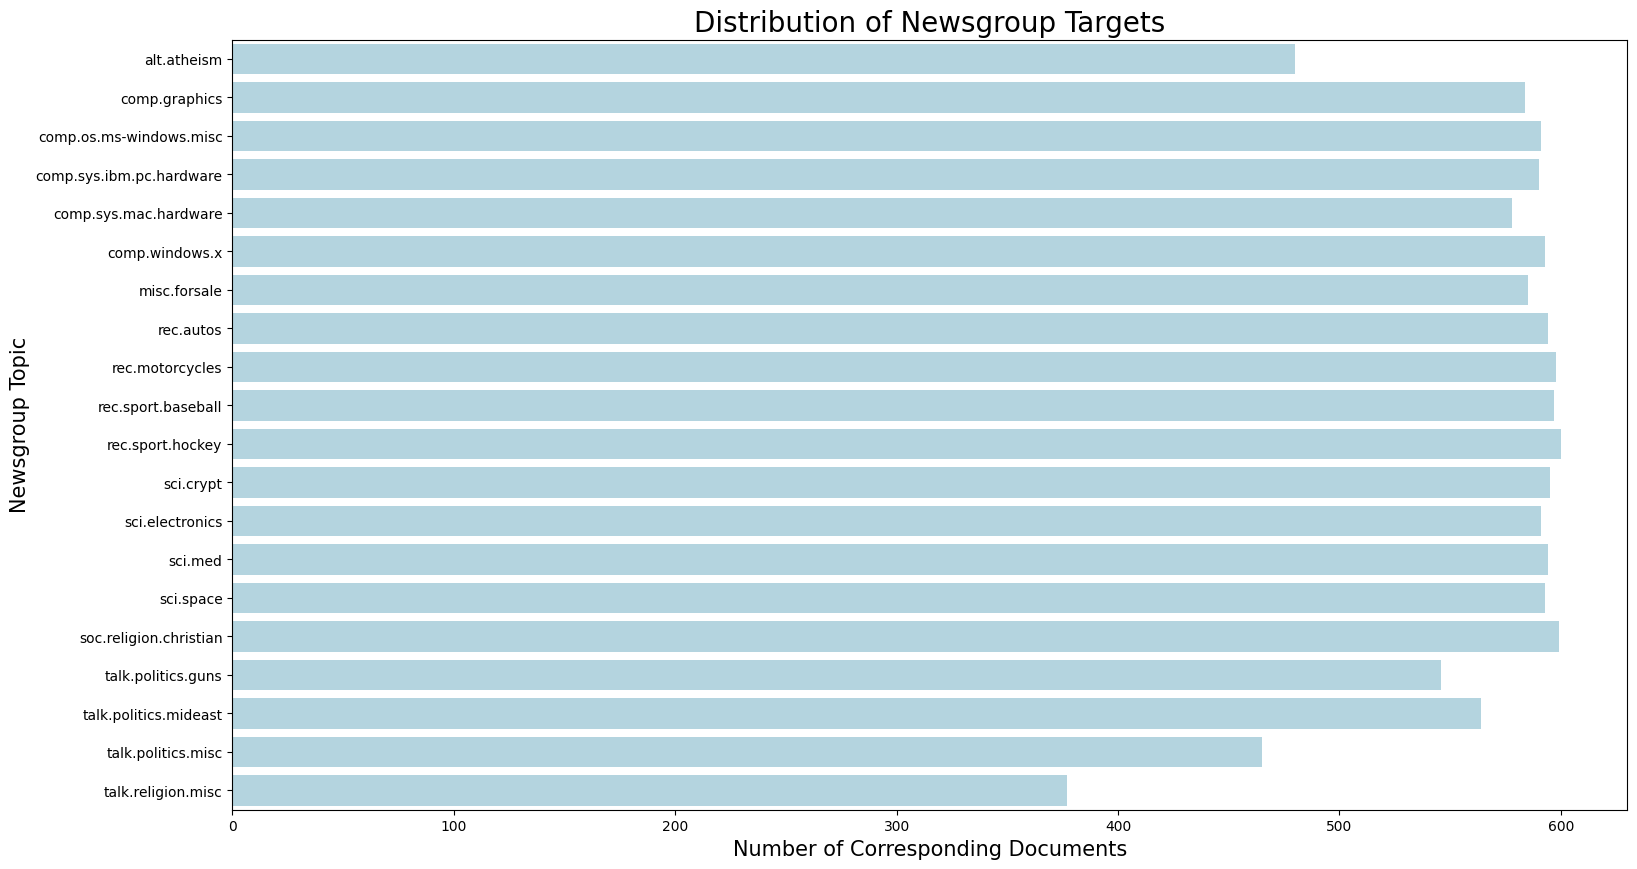

In [255]:
# plot the distribution of the newsgroups
fig1 = plt.figure(figsize =[18 ,10])
ax = sns.countplot(y=newsgroup_df['newsgroup'], color="lightblue", order=dataset.target_names)
plt.title('Distribution of Newsgroup Targets', size=20)
plt.ylabel('Newsgroup Topic', size = 15)
plt.xlabel('Number of Corresponding Documents', size = 15)
plt.show()

Some of the topics overlap in terms of abstract concepts, such as "alt.atheism" and "soc.religion.christian". We are interested in seeing how topic modeling is able to extract different themes from a wide range of subjects, so we will only look at a subset of 10 unique topics that share minimal overlap with other topics. These topics are: graphics, sale, motorcycles, hockey, cryptography, medical, space, religion, guns, and politics on the middle east.

In [256]:
newsgroup_df = newsgroup_df[newsgroup_df["newsgroup"].isin([
    "comp.graphics", "misc.forsale", "rec.motorcycles", 
    "rec.sport.hockey", "sci.crypt", "sci.med",
    "sci.space", "soc.religion.christian", "talk.politics.guns",
    "talk.politics.mideast"
])]

In [257]:
newsgroup_df = newsgroup_df[(newsgroup_df["newsgroup"] != 'talk.politics.misc') & (newsgroup_df["newsgroup"] != 'talk.religion.misc')]
newsgroup_df.shape

(5858, 3)

In [258]:
words_per_document = newsgroup_df["document"].apply(lambda x: len(x.split(" ")))
mean_words = words_per_document.mean()
std_words = words_per_document.std()
print("mean number of words:", mean_words, "standard deviation of number of words:", std_words)

mean number of words: 347.9247183339024 standard deviation of number of words: 725.8041830310069


In [259]:
#total number of distinct words
sum(words_per_document.unique())

1009834

In [260]:
print('max words per document', max(words_per_document), ', min words per document', min(words_per_document))

max words per document 20235 , min words per document 11


We can now preprocess the data for the topic model. We will first clean the documents by removing punctation, numbers, and characters, converting to lowercase, and stripping empty strings. We will also remove non-descriptive words such as "a", "is", "from", "and", etc. We will add additional stop words that occur often in our dataset but do not have any significant meaning for the theme extraction. Lastly, we will lemmatize our documents, meaning we will distill words into their foundational terms, like "running" to "run". This will help reduce unnecessary and redundant terms and ensure a faster runtime.

In [261]:
# List of stop words
#additional_stop_words = set(["article", "subject", 'time','im','thing', 'new', 'said', 'need', 'want', 'did',
                             #'know','like','people','think','writes','just','dont', '___', 'good', 'used',
                            #"use", "think", 'doe', "year", "say", "make", 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax'])
additional_stop_words = set(["edu", "subject", "com", "article", "like", "nntp", "thanks", 
                            "just", "apr", "don", "university", "___"])
stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)

# Splits words on white spaces
def tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def process_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation, numbers, \n, and extra whitespaces
    text = re.sub(r'\d+|[^\w\s]', ' ', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    # only include english dictionary words
    # Tokenize and lemmatize
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(word) for word in tokenizer(text) if word not in stop_words]
    text = [each for each in tokens if len(each) > 2]
    text = [each for each in text if ' ' not in each]
    return " ".join(text)

In [262]:
# Set options to display all rows and columns
newsgroup_df['document'][6]

'From: bmdelane@quads.uchicago.edu (brian manning delaney)\nSubject: Brain Tumor Treatment (thanks)\nReply-To: bmdelane@midway.uchicago.edu\nOrganization: University of Chicago\nLines: 12\n\nThere were a few people who responded to my request for info on\ntreatment for astrocytomas through email, whom I couldn\'t thank\ndirectly because of mail-bouncing probs (Sean, Debra, and Sharon).  So\nI thought I\'d publicly thank everyone.\n\nThanks! \n\n(I\'m sure glad I accidentally hit "rn" instead of "rm" when I was\ntrying to delete a file last September. "Hmmm... \'News?\' What\'s\nthis?"....)\n\n-Brian\n'

In [263]:
process_text(newsgroup_df['document'][6])

'bmdelane quad uchicago brian manning delaney brain tumor treatment reply bmdelane midway uchicago organization chicago line people responded request info treatment astrocytomas email couldn thank directly mail bouncing probs sean debra sharon thought publicly thank sure glad accidentally hit instead trying delete file september hmmm news brian'

In [264]:
newsgroup_df['document'][:10].apply(process_text)

3     jgreen amber joe green weitek organization har...
4     jcm head cfa harvard jonathan mcdowell shuttle...
5     dfo vttoulu tko vtt foxvog douglas rewording s...
6     bmdelane quad uchicago brian manning delaney b...
10    irwin cmptrc lonestar org irwin arnstein recom...
13    dbm lerc nasa gov david mckissock space statio...
14    jllee acsu buffalo johnny lee moving sale summ...
16    nova purdue allen tiff philosophical significa...
21    leunggm odin control utoronto gary leung nhl t...
22    rpwhite navy mil rpwhite catalog hard enhancem...
Name: document, dtype: object

In [265]:
### tokenize the abstracts
newsgroup_df['processed_documents'] = newsgroup_df['document'].apply(process_text)
newsgroup_df['processed_documents']

3        jgreen amber joe green weitek organization har...
4        jcm head cfa harvard jonathan mcdowell shuttle...
5        dfo vttoulu tko vtt foxvog douglas rewording s...
6        bmdelane quad uchicago brian manning delaney b...
10       irwin cmptrc lonestar org irwin arnstein recom...
                               ...                        
11305    shaig composer think shai guday hezbollah orga...
11307    chein eng auburn tsan heui case deal lemon pos...
11309    jim zisfein factory jim zisfein migraine scan ...
11312    steve hcrlgw steven collins sphere point organ...
11313    gunning cco caltech kevin gunning stolen cbr o...
Name: processed_documents, Length: 5858, dtype: object

In [266]:
# Get the top 20 most common words among all the documents

p_text = ' '.join(newsgroup_df['processed_documents'].tolist())

p_text = p_text.split(' ')

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,line,6683
1,organization,5923
2,writes,4053
3,people,3699
4,posting,2918
5,time,2898
6,know,2857
7,think,2502
8,host,2401
9,year,2299


### NMF - Manual Topic Number

Transform lemmatized and cleaned words into a TF-IDF (Term Frequency-Inverse Document Frequency) matrix.

In [316]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.95, min_df=1, max_features=1000)

# Fit and transform the processed abstracts into TF-IDF
tfidf = vectorizer.fit_transform(newsgroup_df['processed_documents'])

In [317]:
def do_nmf(tfidf, n_topics):

    # Specify the number of topics
    nmf_model = NMF(n_components=n_topics)
    W = nmf_model.fit_transform(tfidf)  # Document-topic matrix   (n_samples, n_components)
    H = nmf_model.components_         # Topic-term matrix       (n_components, n_features)
    return W, H, nmf_model

In [318]:
n_topics = 10
W, H, nmf_model = do_nmf(tfidf, n_topics)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [319]:
feature_names = vectorizer.get_feature_names_out()
for index, topic in enumerate(H):
    print(f"Topic #{index + 1}:")
    print(",".join([feature_names[i] for i in topic.argsort()[-10:]]))  # Top 10 words per topic

Topic #1:
say,believe,faith,bible,christ,people,church,jesus,christian,god
Topic #2:
crypto,phone,netcom,algorithm,government,escrow,encryption,clipper,chip,key
Topic #3:
win,year,playoff,season,play,nhl,player,hockey,team,game
Topic #4:
software,new,distribution,offer,mail,host,posting,file,graphic,sale
Topic #5:
reply,computer,science,soon,univ,pittsburgh,bank,gordon,geb,pitt
Topic #6:
state,right,peace,policy,jewish,palestinian,jew,arab,israeli,israel
Topic #7:
pat,alaska,jpl,moon,orbit,digex,access,gov,space,nasa
Topic #8:
handgun,crime,criminal,control,law,right,weapon,firearm,people,gun
Topic #9:
azeri,genocide,greek,turkey,serdar,argic,turk,armenia,turkish,armenian
Topic #10:
bnr,helmet,rider,riding,writes,dog,ride,motorcycle,dod,bike


In [320]:
components = H
terms = vectorizer.get_feature_names_out()

# Function to map words to topics
def top_topics(components, terms, num_words):
    # Create output series
    top_topics = pd.Series(dtype=object)

    for idx, component in enumerate(components):
        # Create a series mapping terms to their probabilities for this topic
        term_topic = pd.Series(component, index=terms)
        # Sort by probabilities in descending order
        term_topic.sort_values(ascending=False, inplace=True)
        # Take the top 5 words for this topic
        top_topics['topic' + str(idx)] = list(term_topic.iloc[:num_words].index)

    return top_topics

# Map words to topics
top_topics_output = top_topics(components, terms, 3)

# Print topics and their associated words
print("Topics\t\tTop Words")
for idx, item in zip(top_topics_output.index, top_topics_output):
    print(f"{idx}\t\t{item}")

Topics		Top Words
topic0		['god', 'christian', 'jesus']
topic1		['key', 'chip', 'clipper']
topic2		['game', 'team', 'hockey']
topic3		['sale', 'graphic', 'file']
topic4		['pitt', 'geb', 'gordon']
topic5		['israel', 'israeli', 'arab']
topic6		['nasa', 'space', 'gov']
topic7		['gun', 'people', 'firearm']
topic8		['armenian', 'turkish', 'armenia']
topic9		['bike', 'dod', 'motorcycle']


In [311]:
# Map words to topics
first_topic = top_topics(components, terms, 1)

# Print topics and their associated words
topics = list(first_topic.apply(lambda x: x[0]))
for i, name in enumerate(topics):
    print(f"Topic{i}:", name)

Topic0: god
Topic1: key
Topic2: game
Topic3: sale
Topic4: pitt
Topic5: israel
Topic6: nasa
Topic7: gun
Topic8: armenian
Topic9: bike


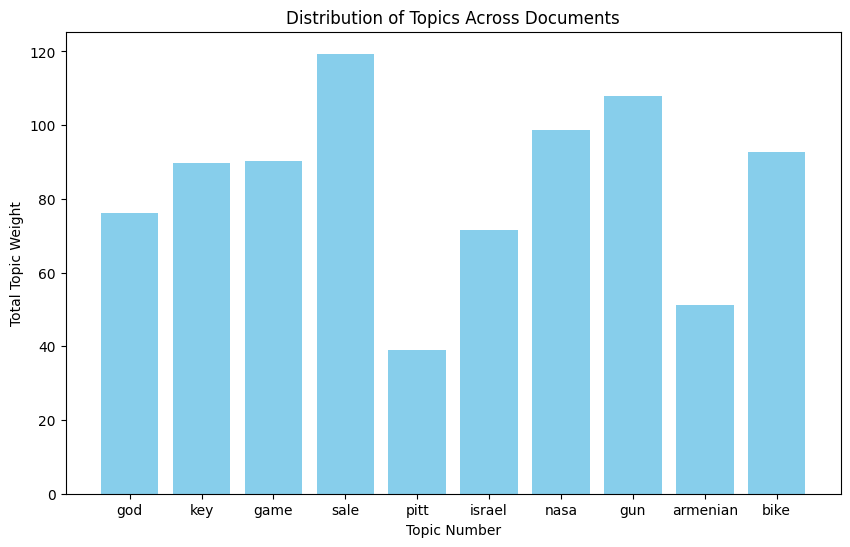

In [321]:
# Transform the documents into topic distributions
document_topics = nmf_model.transform(tfidf)

# Sum the topic weights across all documents
topic_distribution = np.sum(document_topics, axis=0)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(topic_distribution)), topic_distribution, color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Total Topic Weight')
plt.title('Distribution of Topics Across Documents')
plt.xticks(range(len(topic_distribution)), [i for i in topics])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


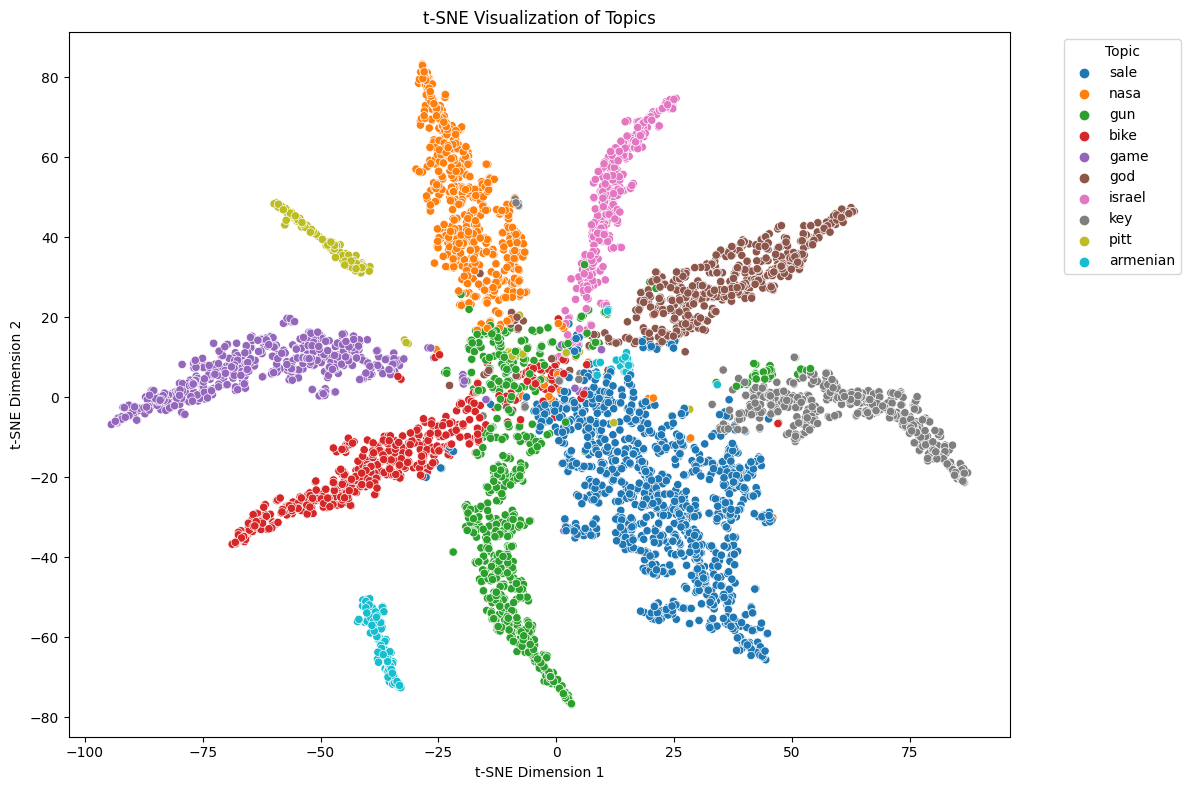

In [330]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define topic names based on your interpretation of the topics
topic_names = {index: topic for index, topic in enumerate(topics)}

# Transform the documents into topic distributions
document_topics = nmf_model.transform(tfidf)

# Assign a dominant topic to each document
dominant_topics = np.argmax(document_topics, axis=1)

# Replace numerical labels with topic names
dominant_topic_names = pd.Series(dominant_topics).map(topic_names)

# Reduce dimensions to 2D using t-SNE
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_values = tsne_model.fit_transform(document_topics)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame({
    "Dimension 1": tsne_values[:, 0],
    "Dimension 2": tsne_values[:, 1],
    "Topic": dominant_topic_names
})

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=tsne_df,
    x="Dimension 1",
    y="Dimension 2",
    hue="Topic",
    palette='tab10',
    legend='full'
)

# Customize plot
plt.title('t-SNE Visualization of Topics')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


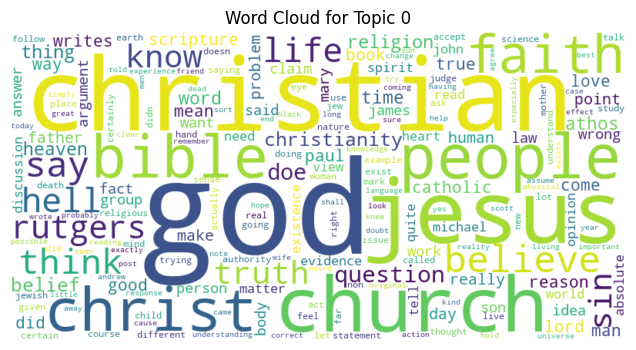

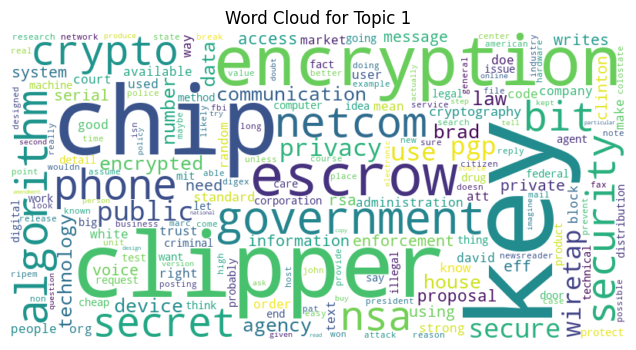

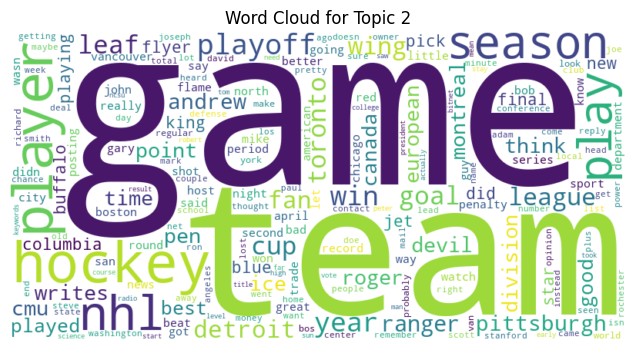

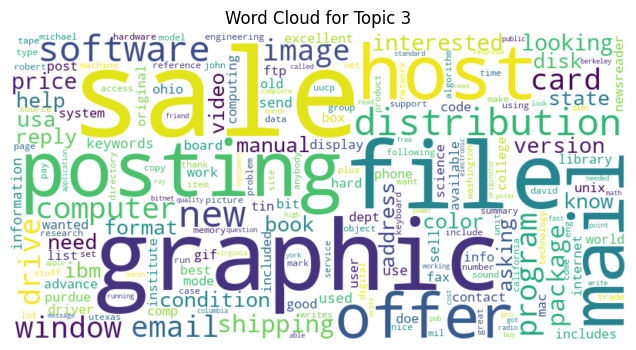

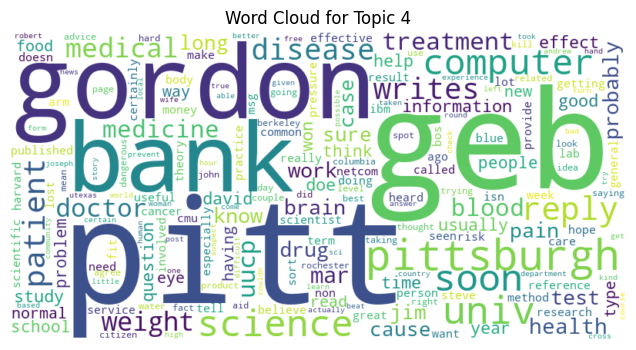

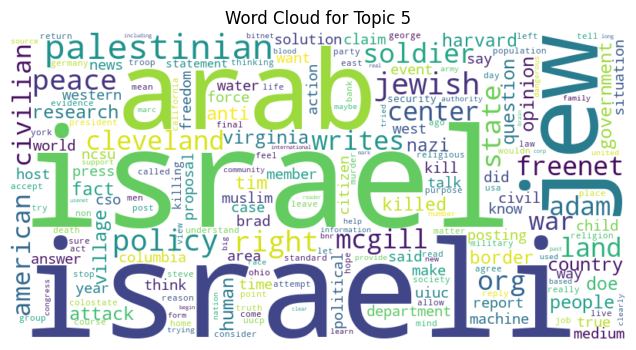

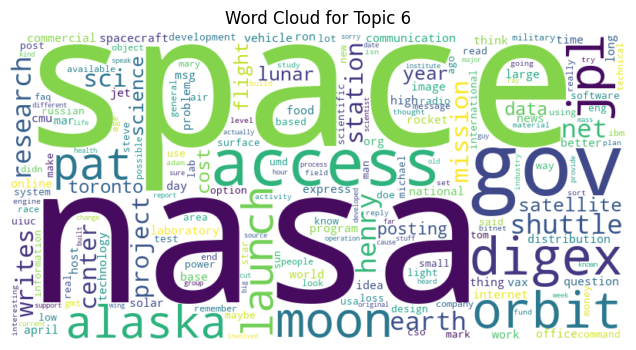

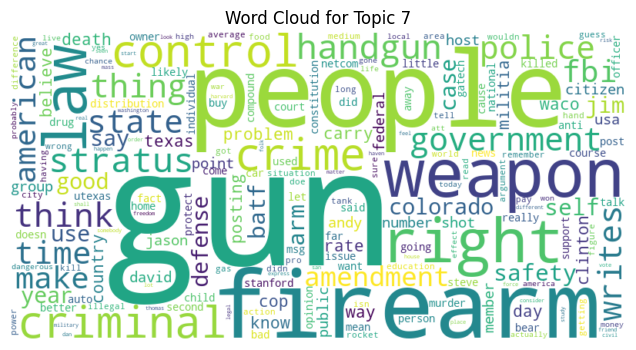

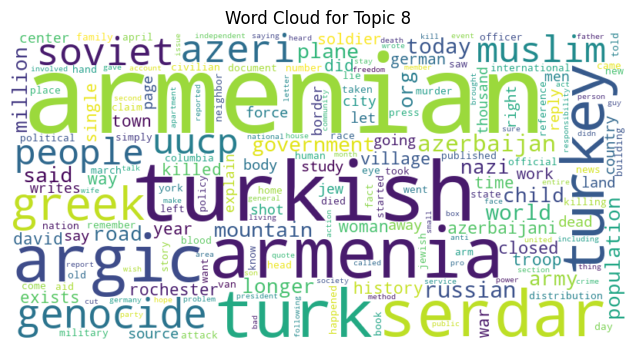

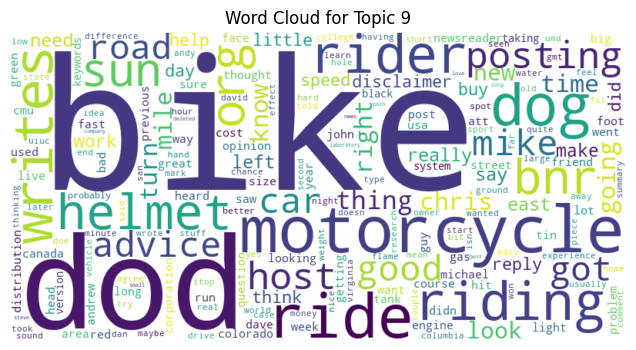

In [331]:
from wordcloud import WordCloud

# Generate a word cloud for each topic
for idx, topic in enumerate(nmf_model.components_):
    # Create a dictionary of words and their probabilities
    word_freq = {terms[i]: topic[i] for i in range(len(terms))}
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Plot the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {idx}")
    plt.show()

In [448]:
# Let's say we want the topic distribution for the first document (index 0)
document_index = 0
document_topics = W[document_index]  # Get topic weights for this document

# Identify the dominant topic for this document
dominant_topic = np.argmax(document_topics)

print(f"Document #{document_index + 1} dominant topic: Topic {dominant_topic + 1}")
print(f"Topic Distribution for Document #{document_index + 1}:")
for topic_idx, weight in enumerate(document_topics):
    print(f"Topic {topic_idx + 1}: {weight:.4f}")

# Print the top words for the dominant topic to understand its meaning
top_word_indices = H[dominant_topic].argsort()[-5:]  # Top 10 words for the dominant topic
print(f"\nTop 5 words for Dominant Topic {dominant_topic + 1}:")
print(" ".join([feature_names[i] for i in top_word_indices]))
print(f"\nActual Newsgroup:")
print(newsgroup_df.iloc[document_index]["newsgroup"])
print(f"\nDocument Content:")
print(newsgroup_df.iloc[document_index]["document"])

Document #1 dominant topic: Topic 4
Topic Distribution for Document #1:
Topic 1: 0.0002
Topic 2: 0.0519
Topic 3: 0.0133
Topic 4: 0.0529
Topic 5: 0.0055
Topic 6: 0.0000
Topic 7: 0.0013
Topic 8: 0.0015
Topic 9: 0.0034
Topic 10: 0.0302

Top 5 words for Dominant Topic 4:
host posting file graphic sale

Actual Newsgroup:
comp.graphics

Document Content:
From: jgreen@amber (Joe Green)
Subject: Re: Weitek P9000 ?
Organization: Harris Computer Systems Division
Lines: 14
Distribution: world
NNTP-Posting-Host: amber.ssd.csd.harris.com
X-Newsreader: TIN [version 1.1 PL9]

Robert J.C. Kyanko (rob@rjck.UUCP) wrote:
> abraxis@iastate.edu writes in article <abraxis.734340159@class1.iastate.edu>:
> > Anyone know about the Weitek P9000 graphics chip?
> As far as the low-level stuff goes, it looks pretty nice.  It's got this
> quadrilateral fill command that requires just the four points.

Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.

--
Joe Green				Harr

Since we know the labels for the themes already, we will compare our themes to the actual themes. Since we were able to correctly extract 8 out of the 10 themes, our accuracy cannot go higher than 80%.

In [392]:
topics

['god',
 'key',
 'game',
 'sale',
 'pitt',
 'israel',
 'nasa',
 'gun',
 'armenian',
 'bike']

In [469]:
correct_topics = ["soc.religion.christian", "sci.crypt", "rec.sport.hockey", "misc.forsale", "incorrect topic 1", 
                  "talk.politics.mideast", "sci.space", "talk.politics.guns", "incorrect topic 2", "rec.motorcycles"]

In [470]:
labeled_topics = {t: l for t, l in zip(topics, correct_topics)}
labeled_topics

{'god': 'soc.religion.christian',
 'key': 'sci.crypt',
 'game': 'rec.sport.hockey',
 'sale': 'misc.forsale',
 'pitt': 'incorrect topic 1',
 'israel': 'talk.politics.mideast',
 'nasa': 'sci.space',
 'gun': 'talk.politics.guns',
 'armenian': 'incorrect topic 2',
 'bike': 'rec.motorcycles'}

In [471]:
def correct_label(document):
    
    document_topics = W[document]
    dominant_topic = np.argmax(document_topics)
    top_word_index = H[dominant_topic].argsort()[-1:]
    
    return labeled_topics[feature_names[top_word_index][0]]

In [472]:
newsgroup_df = newsgroup_df.reset_index().drop(columns=["index"])

In [473]:
newsgroup_df["predicted label"] = newsgroup_df.index.map(correct_label)

In [474]:
newsgroup_df

,document,target,newsgroup,processed_documents,predicted label
0,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,jgreen amber joe green weitek organization har...,misc.forsale
1,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,jcm head cfa harvard jonathan mcdowell shuttle...,sci.space
2,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,talk.politics.guns,dfo vttoulu tko vtt foxvog douglas rewording s...,talk.politics.guns
3,From: bmdelane@quads.uchicago.edu (brian manni...,13,sci.med,bmdelane quad uchicago brian manning delaney b...,misc.forsale
4,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles,irwin cmptrc lonestar org irwin arnstein recom...,rec.motorcycles
...,...,...,...,...,...
5853,From: shaig@composer.think.com (Shai Guday)\nS...,17,talk.politics.mideast,shaig composer think shai guday hezbollah orga...,talk.politics.mideast
5854,From: chein@eng.auburn.edu (Tsan Heui)\nSubjec...,6,misc.forsale,chein eng auburn tsan heui case deal lemon pos...,misc.forsale
5855,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med,jim zisfein factory jim zisfein migraine scan ...,talk.politics.guns
5856,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics,steve hcrlgw steven collins sphere point organ...,sci.space


In [475]:
correct = 0
for n, p, in zip(newsgroup_df["newsgroup"], newsgroup_df["predicted label"]):
    if n == p:
        correct += 1
        
accuracy = correct / 5858
accuracy

0.6712188460225332

#### Residual Score (NMF only)

"Residuals are differences between the observed and predicted values of the data. A residual of 0 means the topic perfectly approximates the text of the article, so the lower the better.

To calculate the residual you can take the Frobenius norm (square root of the sum of the absolute squares of its elements) of the tf-idf weights (A) minus the dot product of the coefficients of the topics (H) and the topics (W). We can then get the average residual for each topic to see which has the smallest residual on average." - https://freedium.cfd/https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45 
<br><br><br>
How well do the topics approximate the original weights of the tfidf matrix for each document?
Averaged across topics, can get the sense of how good of an approximator each topic is.

Residual$[x_i]$$\norm{x_i - W_i \dot H}_F$ where document $x_i \in$ documents $X$, $W_i$ is row i of the Document-topic matrix and $H$ is the Topic-term matrix    

In [361]:
# For each document calculate the difference between the original tfidf weights and those predicted
# by multiplying W and H for that specific row.
# Cell Source: https://freedium.cfd/https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
def do_residual(tfidf, W, H):
    residuals = np.zeros(tfidf.shape[0])
    for row in range(tfidf.shape[0]):
        # 'fro' here means we are using the Frobenium norm as the distance metric
        residuals[row] = np.linalg.norm(tfidf[row, :] - W[row, :].dot(H), 'fro')
    return residuals

residuals = do_residual(tfidf, W, H)
residuals

array([0.95824656, 0.98622811, 0.95354985, ..., 0.98285835, 0.96884261,
       0.98304956])

In [362]:
np.mean(residuals)

0.9378033450733483

Text(0.5, 1.0, 'Average Residual per Document by Main Topic')

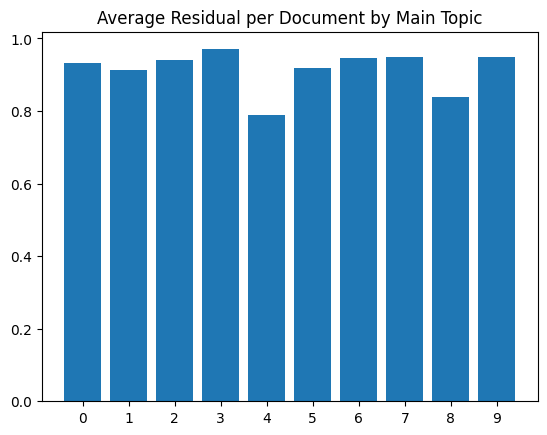

In [363]:
residuals_by_topic = pd.Series(residuals).groupby(np.argmax(W, axis=1)).mean()
plt.bar(x=residuals_by_topic.index, height=residuals_by_topic.values)
plt.xticks(residuals_by_topic.index)
plt.title("Average Residual per Document by Main Topic")

Residuals are nearly indistinguishable by visualization.

In [273]:
residuals_by_topic.sort_values(ascending=False)

2    0.960820
1    0.931396
3    0.927279
4    0.918711
8    0.916310
0    0.893360
6    0.890217
9    0.811616
7    0.784797
5    0.782182
dtype: float64

Topic 1 has the lowest residual while topic 2 has the highest. 

#### "Expert" Manual Evaluation

Since relevance is difficult to interpret without a baseline, we compare the two for quality below by inspecting sets of training instances.

In [377]:
chosen_topic_1 = np.random.choice(np.array(range(tfidf.shape[0]))[np.argmax(W, axis=1)==1], size=5, replace=False)
display([feature_names[i] for i in H[1].argsort()[-10:]])
for i, content in newsgroup_df['document'].iloc[chosen_topic_1].items(): display((i, content))
chosen_topic_2 = np.random.choice(np.array(range(tfidf.shape[0]))[np.argmax(W, axis=1)==2], size=5, replace=False)
display([feature_names[i] for i in H[2].argsort()[-10:]])
for i, content in newsgroup_df['document'].iloc[chosen_topic_2].items(): display((i, content))

['crypto',
 'phone',
 'netcom',
 'algorithm',
 'government',
 'escrow',
 'encryption',
 'clipper',
 'chip',
 'key']

(10922,
 'From: ig25@fg70.rz.uni-karlsruhe.de (Thomas Koenig)\nSubject: Re: White House Public Encryption Management Fact Sheet\nOrganization: University of Karlsruhe, Germany\nLines: 26\nDistribution: na\nNNTP-Posting-Host: fg70.rz.uni-karlsruhe.de\nMime-Version: 1.0\nContent-Type: text/plain; charset=iso-8859-1\nContent-Transfer-Encoding: 8bit\n\nclipper@csrc.ncsl.nist.gov (Clipper Chip Announcement) writes:\n\n>The President has approved a directive on "Public Encryption\n>Management."  The directive provides for the following:\n\n[...]\n\n>When\n>exported abroad, it can be used to thwart foreign intelligence\n>activities critical to our national interests.\n\n[...]\n\n>The Attorney General of the United States, or her representative,\n>shall request manufacturers of communications hardware which\n>incorporates encryption to install the U.S. government-developed\n>key-escrow microcircuits in their products.\n\nQuite interesting.  How does the US administration intend to persuade\nno

(4231,
 "From: koontzd@phobos.lrmsc.loral.com (David Koontz )\nSubject: Re: Will FEDs troll for mutilated law enforcement blocks?\nOrganization: Loral Rolm Mil-Spec Computers\nLines: 43\n\nThe M code stream  might be independently attacked based on knowledge of\nclipper chip protocols as revealed plaintext.  This could be invalidated\nby changing the temporal and or spatial relationship of the clipper M stream\nand the actual transmitted stream, under the control of a secure key\ngenerator synchronized between endpoints.\n\nThe useful life time of captured law enforcement blocks might be limited\nbased on hostile forces using them as targets following transmission\ninterception.  You would need a large number of them, but, hey there's\nsupposed to be millions of these things, right?  Adding time stamps to\nthe encrypted law enforcement block is probably impractical, who wants\nan encryption chip with a real time clock?\n\n****************************************************************

(1085,
 'From: jad@nsa.hp.com (John Dilley)\nSubject: compress | crypt foo | des -e -k foo\nDistribution: sci\nLines: 12\nOrganization: Networked Systems Architecture\n\n\n\tI have a bunch of questions about the encryption scheme\nreferenced in the Subject of this message.  What is the relative data\nprivacy provided by the above sequence as compared with straight DES?\nDoes the addition of compression then encrypting make the cyphertext\nsignificantly harder to crack using current methods than straight DES?\nWould running crypt after DES provide greater data privacy?  Is it\nimportant to remove the (constant) compress header before encryption?\nThank you, net, for your wisdom.\n\n\t\t\t --       jad       --\n\t\t    John A. Dilley <jad@nsa.hp.com>\n')

(5978,
 'From: rlglende@netcom.com (Robert Lewis Glendenning)\nSubject: Re: Estimating Wiretap Costs/Benefits\nOrganization: Netcom - Online Communication Services (408 241-9760 guest)\nLines: 13\n\nI am most embarassed that my irrate, intemperate post is still\ncirculating.\n\nI have been chided by experts for my behavior.  I now agree with\nall of them, although some were no more restrained in their\nspeech than I was 8)\n\nI have apologized to Robin Hanson.\n\nLew\n-- \nLew Glendenning\t\trlglende@netcom.com\n"Perspective is worth 80 IQ points."\tNiels Bohr (or somebody like that).\n')

(7904,
 'From: amolitor@moink.nmsu.edu (Andrew Molitor)\nSubject: What the clipper nay-sayers sound like to me.\nOrganization: Department of Mathematical Sciences\nLines: 55\nDistribution: na\nNNTP-Posting-Host: moink.nmsu.edu\nOriginator: amolitor@moink.nmsu.edu\n\n\tThe following is available in some FTP archive somewhere, I insert\nmy comments liberally throughout this demonic memo of Big Brotherdom:\n\n>\tWhite House Announcement on Screw Thread Standards\n>\t--------------------------------------------------\n>\n>\tThis is to announce that the American National Standards\n>Institute (or whatever it is) has been given the authority to define\n>standard dimensions for screw threads.\n\n   Look! This is clearly the first step toward outlawing our\n   own screw thread specifications. If this madness isn\'t fought,\n   tooth and nail, every step of the way, it\'ll be a crime to use\n   screw threads other than those our Fearless Leaders so *graciously*\n   define for us.\n\n>\tThe purp

['win',
 'year',
 'playoff',
 'season',
 'play',
 'nhl',
 'player',
 'hockey',
 'team',
 'game']

(9486,
 'From: MLINDROOS@FINABO.ABO.FI (Marcus Lindroos INF)\nSubject: Re: expanding to Europe:Dusseldorf\nIn-Reply-To: pkortela@snakemail.hut.fi\'s message of 15 Apr 93 14:47:30 GMT\nOrganization: Abo Akademi University, Finland\nX-News-Reader: VMS NEWS 1.24\nLines: 75\n\nIn <PKORTELA.93Apr15164732@lk-hp-17.hut.fi> pkortela@snakemail.hut.fi writes:\n\n> \n> DEG has many german-born forwards in the team. In fact the majority of players\n> are german-born. 1992-93 DEG had 11150 average in 11800 spectator arena.\n\nInteresting! One of our German friends here (Robert?) told me their forwards\nwere all Canadian-Germans. Perhaps somebody can sort this out for us?\n \n> My Possible-NHL(European league)-site list:\n> Switzerland  : Berne, Zurich (Lugano and 1-2 others)\n\nOK, "this ain\'t North America" and so on, but I still doubt that _any_ city\nhaving a pop. of 500,000 and below could support an NHL team. Of course,\nSwitzerland probably should be judged as one large city because of small

(10644,
 'From: smorris@venus.lerc.nasa.gov (Ron Morris )\nSubject: Re: Wings take game one\nOrganization: NASA Lewis Research Center\nLines: 25\nDistribution: world\nNNTP-Posting-Host: venus.lerc.nasa.gov\nNews-Software: VAX/VMS VNEWS 1.41    \n\nIn  <1qvos8$r78@cl.msu.>, vergolin@euler.lbs.msu.edu (David Vergolini) writes...\n>  The Detroit Red Wings put a lot of doubter on ice tonight with a 6 - 3\n>washing of the Toronto Maple Leafs.  All you Toronto fans have now seen the\n>power of the mighty Red Wing offense.  Toronto\'s defense in no match for the\n>Wing offense.  As for the defense, Probert, Kennedey and Primeau came out\n>hitting hard.  Toronto players were being thrown left and right.  Not even\n>Wendell Clark was tough enough for the Wings tough guys.  The Wings only gave\n>up three goals, a low total for what they say is a mediocre defense.\n>  All you Leaf fans better speak up now.  You team will probable have its\n>season ended soon.  Wings fans, keep up the support.\n\n

(5713,
 "From: 06paul@ac.dal.ca\nSubject: My Predictions of a classic playoff year!\nOrganization: Dalhousie University, Halifax, Nova Scotia, Canada\nLines: 73\n\nHere is yet another prediction for them great playoffs!\n(you may laugh at your convenience!) :)\n\n\tAdams Division (I hate the NE (name) divisoin!!!)\n\nBOS vs BUF   BOS in 5  (the B's are hot lately!)\n\nMON vs QUE   MON in 7  (This will be the series to watch in the first round!)\n\n\nBOS vs MON   MON in 7  (this may be a bit biased but I feel the Canadiens will\n\t\t       (smarten up and start playing they played two months ago\n\t\t\t( i.e. bench Savard !!!)\n\tPatrick Division \n\nPIT vs NJD   PIT in 6  (It wont be a complete cake walk... there be a few lumps\n\t\t\t(in the cake batter!)\n\nWAS vs NYI   WAS in 6  \t(This will not be an exciting series..IMO)\n\n\nPITT vs WAS  PIT in 4   (Washington will be tired after the NYI)\n\n\tNorris Division\n\nCHI vs StL    CHI in 5   (StL will get a lucky game in)\n\nTOR vs DE

(5393,
 'From: MLINDROOS@FINABO.ABO.FI (Marcus Lindroos INF)\nSubject: Finland/Sweden vs.NHL teams (WAS:Helsinki/Stockholm & NHL expansion)\nIn-Reply-To: tervio@katk.Helsinki.FI\'s message of Thu, 15 Apr 1993 09:39:37 GMT\nOrganization: Abo Akademi University, Finland\nX-News-Reader: VMS NEWS 1.24\nLines: 120\n\nIn <tervio.40@katk.Helsinki.FI> tervio@katk.Helsinki.FI writes:\n\n>    Now what if the two teams were merged (this has been proposed in Tampere \n> with Ilves ( =Lynx) and Tappara ( =Axe).  The fans wouldn\'t take it !\n> They rather see their teams out of the playoffs most of the time or even \n> relegated than merged.  It\'s not that difficult to understand, it\'s just \n> like here in Helsinki.  You *grow up* being either a Jokerit- or HIFK -fan.\n> The other team is the last team in the world you would support.  I\'m not \n> talking about \'hate\' but about extremely deeply rooted rivalry.\n\n"Deeply rooted rivalry?" Ahem, Jokerit have been around since 1967 and joined\nth

(11012,
 'From: andrew@idacom.hp.com (Andrew Scott)\nSubject: USENET Playoff Hockey Pool: Game 1 standings\nOrganization: IDACOM, A division of Hewlett-Packard\nLines: 224\n\nHere are the standings after game 1 of each of the divisional semi-finals.\n(Hey, look who\'s #4!)  I\'ll try to post the standings after "each game"\n(i.e. every two days).\n\nI managed to recover the email lost up to Saturday night, so all I\'m missing\nis mail that arrived between early Saturday morning and Sunday afternoon.\nMany people re-sent their teams, so you may have received two replies back\nfrom me.  If your team name is not on this list, please resend your team\nto me and I\'ll see what I can do.  Any kind of "proof" you sent it on the\nweekend will help your case.  :-)  Seriously, this is only a fun pool and\nI trust each person to be honest.\n\nAgain, sorry for any inconvenience, and I hope the pool is still fun for you.\n\n\t- Andrew\n\n\nUSENET Hockey Playoff Draft Standings\n\nPosn\tTeam\t\t\t\t

Both topics seem to be representative of the randomly chosen instances best explained by that topic.

#### Coherence Score for NMF

Coherence score measures the relative distance between words within a topic.

##### TC-W2V Implementation for SKLearn 
Source: https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

<b>Build a Word Embedding</b>

To select the number of topics, here we will use a topic coherence measure called TC-W2V. This measure relies on the use of a word embedding model constructed from our corpus. So in this step we will use the Gensim implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

In [378]:
#First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [386]:
# # Now build a Skipgram Word2Vec model from all documents in the input file using Gensim:

raw_documents = newsgroup_df['processed_documents']
custom_stop_words = stop_words

docgen = TokenGenerator(raw_documents, custom_stop_words)
# # the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = Word2Vec(docgen, vector_size=500, min_count=20, sg=1)

# # Save for later use, so that we do not need to rebuild it:
w2v_model.save("w2v-model.bin")

print("Model has %d terms" % len(w2v_model.wv.key_to_index))

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Model has 6443 terms


In [385]:
# To re-load this model, run
w2v_model = Word2Vec.load("w2v-model.bin")

TypeError: load() missing 1 required positional argument: 'fname'

<b>Selecting the Number of Topics</b>

Once we have our Word2vec model, we can use it as part of our topic coherence approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.


In [387]:
# We use the Word2vec model to calculate coherence scores for each of these models. 
# We will define this coherence score as follows:

def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            try: # sometimes a term NMF identified may not have been identified by w2v
                pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
            except:
                None
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

#We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [388]:
def do_coherence(k, W, H, terms=feature_names):
    """Generates a final coherence score for a NMF model"""
    # where k is number of topics

    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    global temp_top_terms
    temp_top_terms = term_rankings
    curr_coherence = calculate_coherence( w2v_model, term_rankings )
    print("K=%02d: Coherence=%.4f" % ( k, curr_coherence ) )
    return curr_coherence

In [389]:
do_coherence(10, W, H)

K=10: Coherence=0.4369


0.4369148097787467

end sourced code

### NMF - Automatic Topic Number

In practice, a model will not know a-priori the true number of topics in a set, so coherence score can be used as a measure to choose the best topic model across multiple numbers of topics.

In [ ]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(10, 30, 2))
coherence_scores = dict()
nmf_models = dict()

for k in topic_nums:
    curr_W, curr_H = do_nmf(k)
    nmf_models[k] = (curr_W, curr_H)
    coherence_scores[k] = do_coherence(k, curr_W, curr_H)

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums.values(), coherence_scores.values()))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics, coherence_scores[best_num_topics])

K=10: Coherence=0.4485
K=12: Coherence=0.4756


/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


K=14: Coherence=0.4794


/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


K=16: Coherence=0.4859


/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


K=18: Coherence=0.4903


/Users/johndriscoll/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


K=20: Coherence=0.5160
K=22: Coherence=0.5215
K=24: Coherence=0.5140
K=26: Coherence=0.5224
K=28: Coherence=0.5321
28


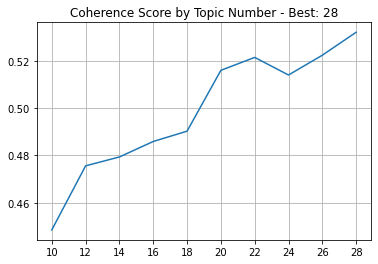

In [169]:
plt.plot(topic_nums, coherence_scores)
plt.title("Coherence Score by Topic Number - Best: {}".format(best_num_topics))
plt.grid(True)
plt.xticks(topic_nums)
plt.show()

In [179]:
# manually selected had residual of 0.98
np.mean(do_residual(tfidf, nmf_models[-1][0], nmf_models[-1][1]))

0.9636908113434091

The matrix chosen by coherence score had a worse residual than the one chosen with 18 features, indicating that selecting by coherence score may not result in the best decomposition, but it is standard practice at the moment.

### Run NMF